# Logistic Regression (Juices dataset)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


## Import local utility functions and classes

In [2]:
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Model configuration

In [3]:
# model mode ('training' or 'predict')
model_mode      = 'training'

# data filenames
data_filename   = '../../data/juices/FTIR_juices.csv'
sample_filename = '../generative_models/ppc_samples_juices.csv'
trace_filename  = './traces/trace_juices'
ppc_filename    = './ppc_samples_juices_predicted.csv'

## Load dataset, import and plot samples

In [4]:
# init dataset object
data_obj = Data(data_filename, 'label', -1)

if model_mode == 'training':    
    data_obj.data.head(5)
else:
    sample_obj = Data(sample_filename, 'label', -1)

NON-Strawberry: blue
Strawberry: red


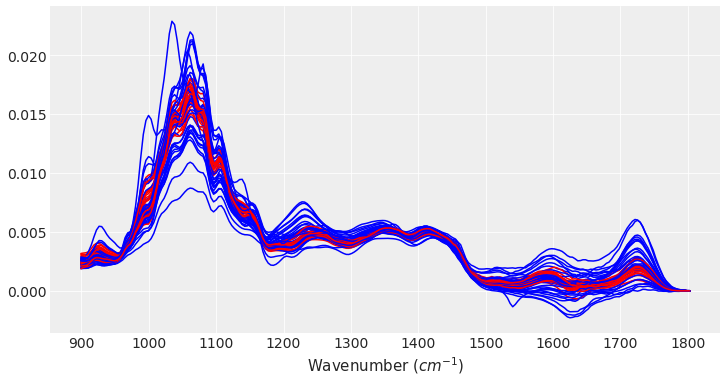

In [5]:
# plot dataframe
if model_mode == 'training':
    utl.plot_data(data_obj, 50)
else:
    utl.plot_data(sample_obj, 10)

In [6]:
# number of samples from each class
if model_mode == 'training':
    print(data_obj.data[data_obj.label_column].value_counts())
else:
    print(sample_obj.data[sample_obj.label_column].value_counts())

NON-Strawberry    632
Strawberry        351
Name: label, dtype: int64


In [7]:
# retrieve a list of k-fold training and test sets
train_lst, test_lst = utl.train_test_split_kfold(data_obj.data, 3)

In [8]:
train_lst[0].shape

(655, 236)

In [9]:
test_lst[0].shape

(328, 236)

# Model definition (Multiple Logistic Regression)
The following statistical model is assumed:

\begin{equation}
\alpha \sim \mathcal{N}(\mu_{\alpha},\,\sigma^{2}_{\alpha}) \\
\beta \sim \mathcal{N}(\mu_{\beta},\,\sigma^{2}_{\beta}) \\
\theta = logistic(\alpha+\beta X) \\
y \sim Bernoulli(\theta)
\end{equation}

In [10]:
traces = []

if model_mode == 'training':
    print("Training model with k-fold cross validation")

for i in range(len(train_lst)):
    if model_mode == 'training':
        print("training on fold: " + str(i+1) + "/" + str(len(train_lst)))
    
    # prepare training data
    Y = pd.Categorical(train_lst[i][data_obj.label_column]).codes
    x_n = train_lst[i].columns[:data_obj.non_data_columns]
    x_s = train_lst[i][x_n].values
    x_s = utl.standardize(x_s)

    with pm.Model() as model_mlr: 
        alpha = pm.Normal('alpha', mu=0, sd=10)
        beta = pm.Normal('beta', mu=0, sd=10, shape=len(x_n))
        mu = alpha + pm.math.dot(x_s, beta)
        theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
        y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 

        if model_mode == 'training':
            trace_mlr = pm.sample(2000, init='adapt_diag', random_seed=42)
            traces.append(trace_mlr)
        else:
            # load traces from trained model
            trace_mlr = pm.backends.text.load(trace_filename)
            break

Training model with k-fold cross validation
training on fold: 1/3


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [52:23<00:00,  1.59draws/s] 
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


training on fold: 2/3


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [51:33<00:00,  1.62draws/s] 


training on fold: 3/3


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [53:06<00:00,  1.57draws/s] 


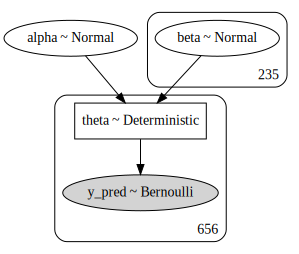

In [11]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [12]:
if model_mode == 'training':
    varnames = ['alpha', 'beta']
    coef = az.summary(trace_mlr, varnames)
    print(coef)

             mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
alpha     -19.446  2.817 -24.622  -14.066      0.051    0.037    3067.0   
beta[0]     1.255  7.197 -11.746   15.011      0.110    0.117    4312.0   
beta[1]    -4.160  7.992 -18.272   11.360      0.116    0.122    4744.0   
beta[2]    -3.353  8.606 -20.349   11.813      0.113    0.144    5831.0   
beta[3]    -1.529  8.724 -18.048   14.549      0.110    0.153    6291.0   
...           ...    ...     ...      ...        ...      ...       ...   
beta[230]  -4.763  7.927 -19.874   10.056      0.124    0.116    4057.0   
beta[231]  -4.452  5.999 -16.015    6.179      0.099    0.089    3694.0   
beta[232] -13.427  5.607 -24.258   -3.151      0.103    0.076    2940.0   
beta[233]  -8.304  4.560 -16.922    0.028      0.077    0.060    3480.0   
beta[234]  17.626  4.134  10.124   25.299      0.074    0.055    3148.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
alpha      2957.0    3131.0    2873.0    1.0  
beta[

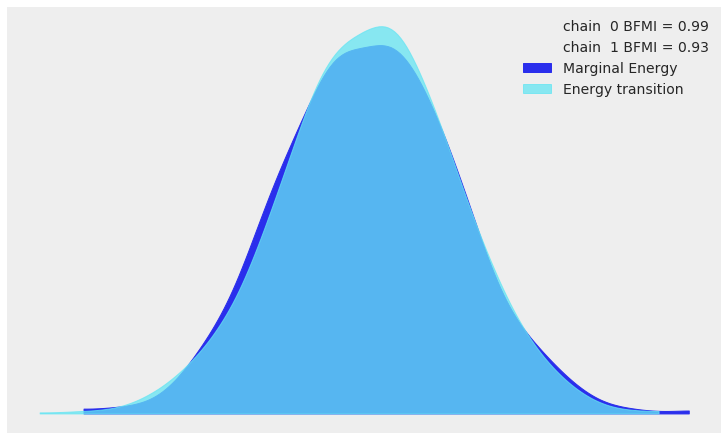

In [13]:
if model_mode == 'training':
    az.plot_energy(trace_mlr, figsize=(10, 6));

# Model predictions

In [14]:
if model_mode == 'training':
    # add model predictions on test dataset
    for i in range(len(traces)):
        test_lst[i] = utl.append_predictions(data_obj, traces[i], test_lst[i], display=False)
else:
    # add model predictions on sample data
    utl.append_predictions_ppc(sample_obj, trace_mlr, display=False)

In [15]:
if model_mode == 'training':
    # prediction score on test dataset
    utl.logistic_score(test_lst, 'label', 'p_label', kfold=True)
else:
    # prediction score on sample data
    utl.logistic_score_ppc(sample_obj, 'p_label')

n   tot  cor  err  score (%)
----------------------------
1    328   323   5   98.5
2    328   320   8   97.6
3    327   320   7   97.9
----------------------------
     983   963   20   98.0


## Save results

In [16]:
if model_mode == 'training':
    # save inference results
    pm.backends.text.dump(trace_filename, trace_mlr)
else:
    # save prediction results
    sample_obj.data.to_csv(ppc_filename, index=False)